# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

## Downloading the data

The data is hosted here. For this guide we will simply download the 500 hPa geopotential data (Z500).

In [2]:
# This might take a few minutes
!wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

--2020-06-07 10:49:05--  https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip
Resolving dataserv.ub.tum.de (dataserv.ub.tum.de)... 138.246.224.34, 2001:4ca0:800::8af6:e022
Connecting to dataserv.ub.tum.de (dataserv.ub.tum.de)|138.246.224.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532774663 (1,4G) [application/zip]
Saving to: ‘geopotential_500_5.625deg.zip’

geopotential_500_5. 100%[===================>]   1,43G  25,0MB/s    in 60s     

2020-06-07 10:50:06 (24,4 MB/s) - ‘geopotential_500_5.625deg.zip’ saved [1532774663/1532774663]



In [3]:
!mkdir -p geopotential_500
!unzip -d geopotential_500/ geopotential_500_5.625deg.zip

Archive:  geopotential_500_5.625deg.zip
  inflating: geopotential_500/geopotential_500hPa_1979_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1980_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1981_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1982_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1983_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1984_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1985_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1986_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1987_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1988_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1989_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1990_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1991_5.625deg.nc  
  inflating: geopotential_500/geopotential_500hPa_1992_5.625deg

## Open the data

In [6]:
wb1_dir='/run/media/adamh/HOME'

def xr_open(path): 
    return xr.open_mfdataset(wb1_dir+'/'+path+'/*.nc', combine='by_coords')

constants=xr_open('constants')
_temperature=xr_open('2m_temperature')
temperature=xr_open('temperature')
temperature_850=xr_open('temperature_850')
_u_component_of_wind=xr_open('10m_u_component_of_wind')
_v_component_of_wind=xr_open('10m_v_component_of_wind')
u_component_of_wind=xr_open('u_component_of_wind')
v_component_of_wind=xr_open('v_component_of_wind')
geopotential=xr_open('geopotential')
geopotential_500=xr_open('geopotential_500')
relative_humidity=xr_open('relative_humidity')
specific_humidity=xr_open('specific_humidity')
potential_vorticity=xr_open('potential_vorticity')
vorticity=xr_open('vorticity')
toa_incident_solar_radiation=xr_open('toa_incident_solar_radiation')
total_cloud_cover=xr_open('total_cloud_cover')
total_precipitation=xr_open('total_precipitation')

In [3]:
#constants
#_temperature
#temperature
#temperature_850
#_u_component_of_wind
#_v_component_of_wind
#u_component_of_wind
#v_component_of_wind
#geopotential
#geopotential_500
#relative_humidity
#specific_humidity
#potential_vorticity
#vorticity
#toa_incident_solar_radiation
#total_cloud_cover
#total_precipitation

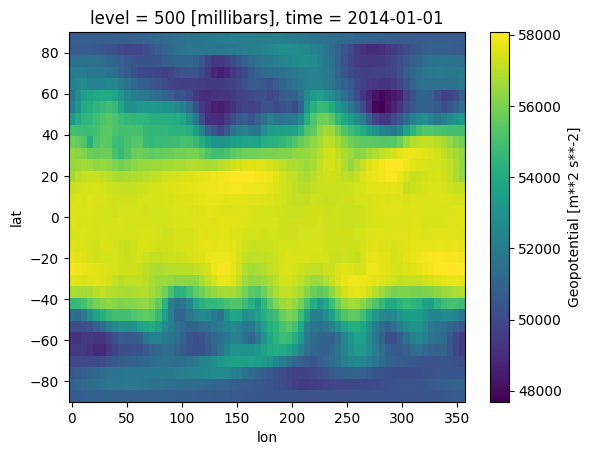

In [7]:
# Plots the geopotential height (z) at the initial time step from the z500 dataset
geopotential_500.z.isel(time=0).plot();

## Create a simple climatological forecast

Remember that we are using the years 2017 and 2018 for testing/evaluation, so we are not allowed to use these years to train any data-driven model.

For more information on the climatology and persistence forecasts used in the paper check out `notebooks/1-climatology-persistence.ipynb`.

In [8]:
# To speed things up we will just take the mean for 2016
climatology = geopotential_500.sel(time=slice('2016', '2016')).mean('time').load()

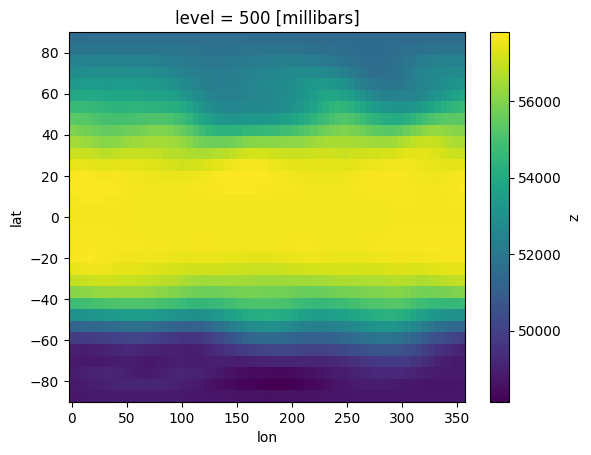

In [9]:
climatology.z.plot()

### Evaluate the climatology

Please check the paper for details on the evaluation metric. Here we will use the functions from `src/score.py`. To make sure we are always using the same targets for testing, we also implemented a function to load the test data.

In [12]:
from wb1_score import *

In [13]:
z500_test = load_test_data(wb1_dir+'/geopotential_500/', 'z')[::12]  # Take data only every 12 hours to speed up computation on Binder

In [14]:
rmse_climatology = compute_weighted_rmse(climatology.z, z500_test).load()

In [15]:
rmse_climatology

<xarray.DataArray ()>
array(1079.88382283)
Coordinates:
    level    int32 500

So we get a climatological RMSE of 1080 m^2/s^2 which is very similar to the RMSE we get for the climatology for all training years.

## Train a neural network

Now let's train a simple convolutional neural network. We are using several functions defined in `src/train_nn.py`. You can use and modify these or write your own function for data loading etc. 

For more information on the the networks check out `notebooks/3-cnn-example.ipynb`.

In [18]:
from wb1_train_nn import *

2024-04-15 15:21:55.291223: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:21:55.318724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:21:55.319790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 15:21:56.155229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
# This limits TF memory usage on the GPU
# limit_mem()

First, we need to create the data generators for training, validation and testing. The main reason why we are using data generators instead of just loading the data as Numpy arrays is that this would require loading the same data twice since the features and targets are the same fields, just offset in time. 

In [19]:
bs = 32
lead_time = 5*24
var_dict = {'z': None}

In [20]:
# Use 2015 for training and 2016 for validation
dg_train = DataGenerator(
    geopotential_500.sel(time=slice('2015', '2015')), var_dict, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    geopotential_500.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [21]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(geopotential_500.sel(time=slice('2017', '2018')).isel(time=slice(0, None, 12)), # Limiting the data for Binder
                        var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [22]:
X, y = dg_train[0]

In [23]:
# Batches have dimensions [batch_size, lat, lon, channels]
X.shape, y.shape

((32, 32, 64, 1), (32, 32, 64, 1))

Now let's build a simple fully convolutional network. We are using periodic convolutions in the longitude direction. These are defined in `train_nn.py`.

In [24]:
cnn = keras.models.Sequential([
    PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)),
    PeriodicConv2D(filters=1, kernel_size=5)
])

2024-04-15 15:22:13.289642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 15:22:13.290095: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 periodic_conv2d (PeriodicC  (None, 32, 64, 32)        832       
 onv2D)                                                          
                                                                 
 periodic_conv2d_1 (Periodi  (None, 32, 64, 1)         801       
 cConv2D)                                                        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [27]:
# Train a little bit ;)
cnn.fit(dg_train, epochs=1, validation_data=dg_valid)

270/270 [==============================] - 25s 92ms/step - loss: 2.2432 - val_loss: 1.0162


### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [28]:
preds = create_predictions(cnn, dg_test)

/home/adamh/vs_venv_p3.8/w_code/wb1_train_nn.py:142: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(dg)


In [29]:
preds

<xarray.Dataset>
Dimensions:  (time: 1340, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-02 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 5.132e+04 5.139e+04 ... 5.264e+04

In [30]:
compute_weighted_rmse(preds.z, z500_test).load()

<xarray.DataArray ()>
array(1253.50682009)
Coordinates:
    level    int32 500

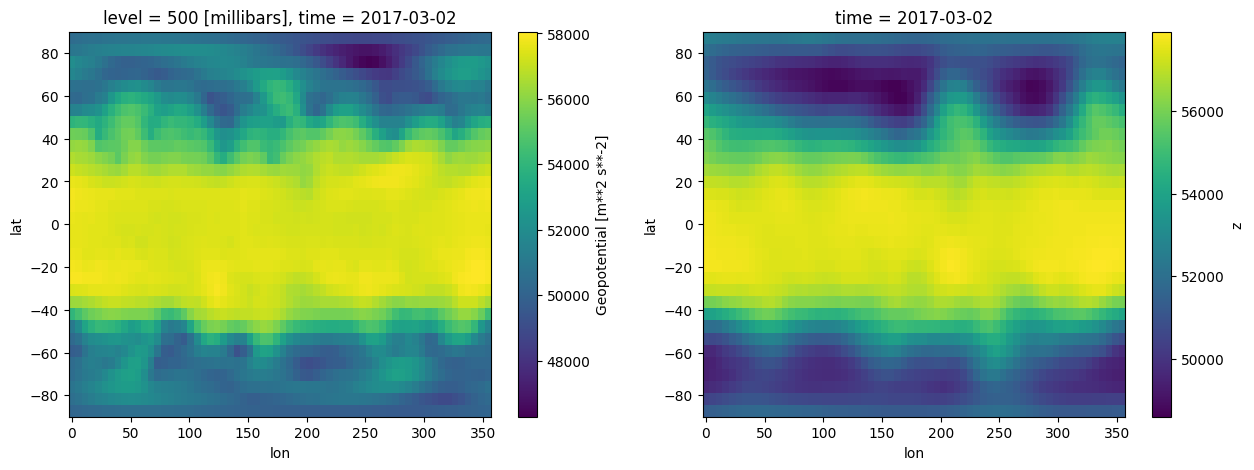

In [31]:
time = '2017-03-02T00'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
z500_test.sel(time=time).plot(ax=ax1)
preds.sel(time=time).z.plot(ax=ax2);

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.